In this notebook we explore the effects of white-box evasion attacks on the MARVEL dataset, as well as several metrics and defences - the latter encompassing image preprocessing (i.e. input transformations) and adversarial training.

**Load prerequisites**

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

from keras_radam import RAdam

import cv2
import os
import glob

import numpy as np
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import TotalVarMin, SpatialSmoothing, PixelDefend, FeatureSqueezing
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.metrics import empirical_robustness, clever_u
from art.data_generators import KerasDataGenerator
from art.utils import load_mnist, load_cifar10, load_dataset

**Load MARVEL dataset**

In [59]:
x_train = []
y_train = []
x_test = []
y_test = [] 
min_pixel_value = 0
max_pixel_value = 1

def marvel_class(filename):
    switcher={
        'HeavyLoadCarrier': 0,
        'CombatVessel': 1,
        'ContainerShip': 2,
        'PassengersShip': 3,
        'Ro-roCargo': 4,
        'Tanker': 5,
        'Tug': 6,
        'SupplyVessel': 7,
        'Yacht': 8 
    }
    return switcher.get(filename)

def load_training_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/train_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_train.append(img/255)
            y_train.append(marvel_class(filename))
    return x_train, y_train

def load_test_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/test_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_test.append(img/255)
            y_test.append(marvel_class(filename))
    return x_test, y_test

# for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/train_9"):
#     load_training_data(filename)
#     print(filename)

for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/test_9"):
    load_test_data(filename)
    print(filename)
    
#load_training_data("/home/cyber/Desktop/Adrian/marvel_data/test_9/CombatVessel")


CombatVessel
Yacht
Ro-roCargo
ContainerShip
PassengersShip
Tanker
HeavyLoadCarrier
SupplyVessel
Tug


**Modification: Convert x_test/x_train from uint8 into float32, to enable classification**

In [60]:
x_test = np.array(x_test, dtype=np.float32)

In [57]:
# print(x_test[1].shape)
# print(y_test)
# len(y_test)
# print(x_test[:10])
# x_test[1].dtype
print(np.argmax(predictions[3))
print(y_test[1])

2
1


**Modification: Disabling eager execution to enable Section 1, Step 3**

In [36]:
tf.compat.v1.disable_eager_execution()

**Section 1 - Attacks**

Step 1: Load/Create the classifier model 

In [61]:
# model = load_model("/home/cyber/basicmodel.h5")
# model = load_model("/home/cyber/cifar10trainedmodel.h5")

model = load_model("/home/cyber/Desktop/Adrian/Xception-10-0.74.hdf5", custom_objects={'RAdam': RAdam}, compile =False)

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Optional step: Train and save the ART classifier for future use

In [62]:
# classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

In [63]:
# classifier.save("/home/cyber/marveltrainedmodel.h5")

Step 2: Evaluate the ART classifier on benign test examples

In [78]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)

print("Undefended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Undefended classifier
Accuracy on benign test examples: 81.08419838523645%


Step 3: Craft adversarial examples

In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.2)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)
#adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv_CW = adv_crafter.generate(x_test)


In [ ]:
adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.2)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)
#adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv_JSMA = adv_crafter.generate(x_test)


In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
adv_crafter = ProjectedGradientDescent(classifier, eps=0.3)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)
#adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv_PGD = adv_crafter.generate(x_test)


In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.3)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)
#adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv_DeepFool = adv_crafter.generate(x_test)


In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(classifier, eps=0.3)
#adv_crafter = FastGradientMethod(estimator=classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=classifier, verbose=True)
adv_crafter = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

#x_train_adv = adv_crafter.generate(x_train)
x_test_adv_BIM = adv_crafter.generate(x_test)


Step 4: Evaluate the ART classifier on the adversarial test set

In [82]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Undefended classifier")
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Undefended classifier
Accuracy on adversarial test examples: 0.0%


<ipython-input-82-e57fe89f0f06>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)


Optional step: Plot images and their adversarial counterparts for reference

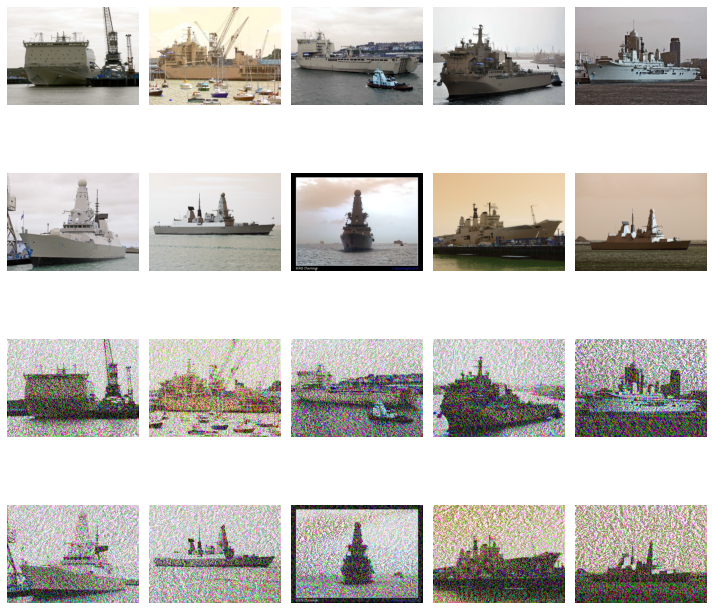

In [83]:
num = 10
images = x_test[:num]
adv_examples = x_test_adv[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

**Section 2 - Metrics**

Metric 1: Empirical Robustness

In [ ]:
attack_name = "fgsm"
score = empirical_robustness(classifier=classifier, x=x_test, attack_name=attack_name)
print("Empirical robustness of the classifier against {}: {}".format(attack_name, score))

Metric 2: CLEVER

In [ ]:
score = clever_u(classifier=classifier, x=x_test[1], nb_batches=10, batch_size=64, radius=25,norm=2)
print("CLEVER score of the classifier against an untargeted attack: {}".format(score))

**Section 3 - Defence**

Save original adversarial examples for reference

In [ ]:
x_test_adv_original = x_test_adv

Creating a seperate 'robust' classifier, to enable side-by-sde analysis of both the original and defended model

In [ ]:
model = load_model("/home/cyber/basicmodel.h5")
robust_classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Defence 1: Preprocessing

Step 1: Input transformation

In [ ]:
#defence = TotalVarMin(verbose = True)
defence = SpatialSmoothing(window_size=5)
#defence = PixelDefend(clip_values=(min_pixel_value, max_pixel_value), eps=16, pixel_cnn = robust_classifier, verbose=True)
#defence = FeatureSqueezing(clip_values=(min_pixel_value, max_pixel_value), bit_depth=8)

x_test_adv = defence(x_test_adv_original * 255)[0] / 255

#what does * 255)[0] / 255 do?

Additional step: Plot images and their adversarial counterparts, pre- and post-transformed, for reference

In [ ]:
num = 10
images = x_test[:num]
transformed_adv_examples = x_test_adv[:num]
pretransformed_adv_examples = x_test_adv_original[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(6, 5, i + 11)
    plt.imshow(pretransformed_adv_examples[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(6, 5, i + 21)
    plt.imshow(transformed_adv_examples[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
    
plt.tight_layout()
plt.show()

Defence 2: Adversarial Training

Adversarial Training: Method 1 - Data Generators

Step 1: Build a Keras image augmentation object and wrap it in ART

In [ ]:
batch_size = 50
datagen = ImageDataGenerator(
    width_shift_range=0.125, height_shift_range=0.125, fill_mode="constant", cval=0.0
)
datagen.fit(x_train)
art_datagen = KerasDataGenerator(
    datagen.flow(x=x_train, y=y_train, batch_size=batch_size, shuffle=True),
    size=x_train.shape[0],
    batch_size=batch_size,
)

Step 2: Create adversarial trainer

In [ ]:
#adv_crafter = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)
adv_trainer = AdversarialTrainer(classifier=robust_classifier, attacks=adv_crafter, ratio=1.0)

Step 3: Perform adversarial training

In [ ]:
#adv_trainer.fit_generator(generator=art_datagen, nb_epochs=5)
adv_trainer.fit(x_train, y_train, nb_epochs=5, batch_size=50)

Optional step: Save the adversarially trained classifier for future use

In [ ]:
#classifier.save("/home/cyber/pdg_defended_model.h5")

Adversarial Training: Alternative method - Load an existing adversarially trained model

In [ ]:
# path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
#                 url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
# robust_classifier_model = load_model(path)
# robust_classifier = KerasClassifier(clip_values=(min_pixel_value, max_pixel_value), model=robust_classifier_model, use_logits=False)

Defence: Evaluation of effectiveness

Step 1: Evaluate the defended model on the clean test set

In [ ]:
predictions = robust_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Step 2: Evaluate the defended model on the original adversarial test set

In [ ]:
predictions = robust_classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on original adversarial test examples: {}%".format(accuracy * 100))

Step 3: Evaluate the defended model on new adversarial examples produced on the defended model

In [ ]:
#adv_crafter = SaliencyMapMethod(classifier=robust_classifier, theta = 1, verbose=True)
#adv_crafter = ProjectedGradientDescent(robust_classifier, eps=0.2)
adv_crafter = FastGradientMethod(estimator=robust_classifier, eps=0.3)
#adv_crafter = DeepFool(classifier=robust_classifier, epsilon=0.2)
#adv_crafter = NewtonFool(classifier=robust_classifier, verbose=True)
#adv_crafter = CarliniL2Method(classifier=robust_classifier, verbose=True)
#adv_crafter = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

x_test_adv_new = adv_crafter.generate(x_test)

#The following line is for when a preprocessing defence is used
#x_test_adv = defence(x_test_adv * 255)[0] / 255

predictions = robust_classifier.predict(x_test_adv_new)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Defended classifier")
print("Accuracy on new adversarial test examples: {}%".format(accuracy * 100))

Optional step: Plot images, their original adversarial counterparts, and their new adversarial counterparts for reference

In [ ]:
num = 10
images = x_test[:num]
adv_examples_new = x_test_adv_new[:num]
#labels = y_train[:num]

#plot images
plt.figure(figsize=(10, 10))

for i in range(num):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(6, 5, i + 11)
    plt.imshow(adv_examples[i], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(6, 5, i + 21)
    plt.imshow(adv_examples_new[i], cmap='gray')
    plt.axis("off")
    
    #plt.title('Label: {:}'.format(labels[i]))
    #ax.set_title('Label: {}'.format(labels[i]))
 
plt.tight_layout()
plt.show()

Step 4: Compare the performance of the original and the robust classifier against FGSM over a range of eps values

In [ ]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy_original = []
accuracy_robust = []

adv_crafter = FastGradientMethod(classifier)
adv_crafter_robust = FastGradientMethod(robust_classifier)

for eps in eps_range:
    adv_crafter.set_params(**{'eps': eps})
    adv_crafter_robust.set_params(**{'eps': eps})
    x_test_adv = adv_crafter.generate(x_test[:100])
    x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
    predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
    accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
    predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

eps_range = eps_range

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
#legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy (%)')
plt.show()

**Unused**

**Load MNIST dataset**

In [29]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
# x_train, y_train = x_train[:10000], y_train[:10000]
# x_test, y_test = x_test[:500], y_test[:500]

**Load CIFAR-10 dataset**

In [ ]:
# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
# x_train, y_train = x_train[:5000], y_train[:5000]
# x_test, y_test = x_test[:100], y_test[:100]

In [ ]:
# model = Sequential()
# model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# model.compile(
#     loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
# )

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
# model.add(Activation("relu"))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10))
# model.add(Activation("softmax"))

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])